In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import time
from time import gmtime , strftime
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In [3]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

session = sagemaker.Session()

role = get_execution_role()

In [4]:
boston = load_boston()

In [6]:
X_bos_pd = pd.DataFrame(boston.data , columns = boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

X_train , X_test , Y_train , Y_test = sklearn.model_selection.train_test_split(X_bos_pd,Y_bos_pd,test_size = 0.33)
X_train , X_val , Y_train , Y_val = sklearn.model_selection.train_test_split(X_train,Y_train,test_size = 0.33)

In [7]:
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [8]:
X_test.to_csv(os.path.join(data_dir,'test.csv'),header=False,index =False)

pd.concat([Y_val,X_val]).to_csv(os.path.join(data_dir,'validation.csv'), header=False ,index = False)
pd.concat([Y_train,X_train]).to_csv(os.path.join(data_dir,'train.csv'), header = False , index = False)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/indexes/range.py:453: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  return self._int64index.union(other)


In [20]:
prefix = 'boston-xgboost-LL'

train_location = session.upload_data(os.path.join(data_dir,'train.csv'),key_prefix = prefix)
test_location = session.upload_data(os.path.join(data_dir,'test.csv'),key_prefix = prefix)
val_location = session.upload_data(os.path.join(data_dir,'validation.csv'),key_prefix = prefix)

In [24]:
container = get_image_uri(session.boto_region_name , 'xgboost')
training_params ={}
training_params['RoleArn'] = role
training_params['AlgorithmSpecification'] = {'TrainingImage':container , 'TrainingInputMode':'File'}

training_params['OutputDataConfig'] ={'S3OutputPath':'s3://'+session.default_bucket()+'/'+prefix + '/output'}

training_params['ResourceConfig'] = {'InstanceCount': 1 ,
                                     'InstanceType':'ml.m4.xlarge',
                                     'VolumeSizeInGB':5}

training_params['StoppingCondition'] = {'MaxRuntimeInSeconds':86400}

training_params['HyperParameters'] ={'max_depth':'5',
                                     'eta':'0.2',
                                     'gamma':'4',
                                     'min_child_weight':'6',
                                     'subsample':'0.8',
                                     'objective':'reg:linear',
                                     'early_stopping_rounds':'10',
                                     'num_round':'200'}
training_params['InputDataConfig'] = [{'ChannelName':"train",'DataSource':{
                            'S3DataSource':{'S3DataType':'S3Prefix',
                                            'S3Uri':train_location,
                                            'S3DataDistributionType':'FullyReplicated'}},
                                      'ContentType':'csv',
                                      'CompressionType':'None'},
                                      
                                      
                                     {'ChannelName':"validation",'DataSource':{
                            'S3DataSource':{'S3DataType':'S3Prefix',
                                            'S3Uri':valid_location,
                                            'S3DataDistributionType':'FullyReplicated'}},
                                      'ContentType':'csv',
                                      'CompressionType':'None'},]

In [25]:
training_job_name = 'xgboost-boston-'+strftime('%Y-%m-%d-%H-%M-%S' , gmtime())
training_params['TrainingJobName'] = training_job_name
training_job = session.sagemaker_client.create_training_job(**training_params)

In [26]:
session.logs_for_job(training_job_name , wait = True)

2019-04-29 14:39:27 Starting - Launching requested ML instances......
2019-04-29 14:40:28 Starting - Preparing the instances for training......
2019-04-29 14:41:11 Downloading - Downloading input data...
2019-04-29 14:41:41 Training - Downloading the training image.
Arguments: train
[2019-04-29:14:42:01:INFO] Running standalone xgboost training.
[2019-04-29:14:42:01:INFO] File size need to be processed in the node: 0.03mb. Available memory size in the node: 8407.09mb
[2019-04-29:14:42:01:INFO] Determined delimiter of CSV input is ','
[14:42:01] S3DistributionType set as FullyReplicated
[14:42:01] 454x13 matrix with 5675 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-04-29:14:42:01:INFO] Determined delimiter of CSV input is ','
[14:42:01] S3DistributionType set as FullyReplicated
[14:42:01] 224x13 matrix with 2800 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[14:42:01] src/tree/updater_prune.cc:74: tree


2019-04-29 14:42:13 Uploading - Uploading generated training model
2019-04-29 14:42:13 Completed - Training job completed
Billable seconds: 63


In [27]:
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
model_artifacts = train_job_info['ModelArtifacts']['S3ModelArtifacts']

In [32]:
model_name = training_job_name + '-model'
primary_container = {"Image":container , 'ModelDataUrl':model_artifacts}
model_info = session.sagemaker_client.create_model(ModelName = model_name,
                                                  ExecutionRoleArn = role,
                                                  PrimaryContainer = primary_container)

In [37]:
transform_job_name = 'boston-xgboost-batch-transform-'+strftime('%Y-%m-%d-%H-%M-%S' , gmtime())
transform_request = {
    
    'TransformJobName':transform_job_name,
    'ModelName':model_name,
    'MaxConcurrentTransforms':1, #一次該使用幾個計算實例
    'MaxPayloadInMB':6, 
    'BatchStrategy':'MultiRecord',
    'TransformOutput':{'S3OutputPath':'s3://{}/{}/batch-transform/'.format(session.default_bucket(),prefix)},
    'TransformInput':{'ContentType':'text/csv',
                      'SplitType': 'Line',
                      'DataSource':{'S3DataSource':{'S3DataType':'S3Prefix',
                                                    'S3Uri':test_location}}},
    'TransformResources':{'InstanceType':'ml.m4.xlarge',
                          'InstanceCount':1}
}

In [38]:
transform_response = session.sagemaker_client.create_transform_job(**transform_request)

In [39]:
transform_desc = session.wait_for_transform_job(transform_job_name)

...............................!


In [40]:
transform_output = 's3://{}/{}/batch-transform/'.format(session.default_bucket(),prefix)

In [41]:
!aws s3 cp --recursive $transform_output $data_dir

download: s3://sagemaker-us-east-2-802608965906/boston-xgboost-LL/batch-transform/test.csv.out to ../data/boston/test.csv.out


In [42]:
Y_pred = pd.read_csv(os.path.join(data_dir,'test.csv.out'),header = None)

Text(0.5,1,'Median Price vs Predicted Price')

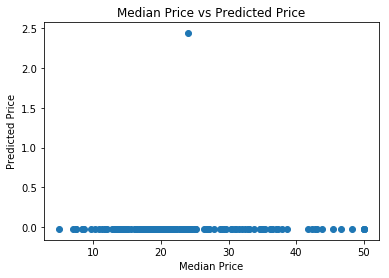

In [44]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

In [45]:
!rm $data_dir/*
!rmdir $data_dir